In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import numpy as np
from torch.utils.data import Dataset

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/proj5/

!pip install einops

import math
import torch.nn.functional as F
import numpy as np
import einops

from torch.utils.data import DataLoader
import skimage
import skimage.io as skio
from matplotlib import pyplot as plt

import cv2

!pip install viser

import viser, time
import numpy as np

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/proj5


In [2]:
class MyDataset(Dataset):
  def __init__(self, image, num_iterations, num_pixels):
    self.image = image / 255
    self.num_iterations = num_iterations
    self.num_pixels = num_pixels
    self.height = self.image.shape[0]
    self.width = self.image.shape[1]
    self.yindices = torch.arange(self.height)/self.height
    self.xindices = torch.arange(self.width)/self.width
    # y, x = torch.meshgrid(torch.arange(self.height), torch.arange(self.width))
    # self.yindices = torch.flatten(y)
    # self.xindices = torch.flatten(x)
    # self.indices = torch.cat((self.yindices[:, None]/self.height, self.xindices[:, None]/self.width), dim=1)
    # self.yindices = self.yindices[torch.randperm(self.yindices.size(0))]
    # self.xindices = self.xindices[torch.randperm(self.xindices.size(0))]

    # TODO: Iterate over files in dataset path, add image and label paths to lists.
    # TODO: Randomly split into train and test partitions. Make sure the random split is the same each time.

  def __getitem__(self, index: int):
    # y, x = torch.meshgrid(torch.arange(self.image.shape[0]), torch.arange(self.image.shape[1]))
    # y = torch.flatten(y)
    # x = torch.flatten(x)
    # yindices = y[torch.randperm(y.size(0))][:self.num_pixels]
    # xindices = x[torch.randperm(x.size(0))][:self.num_pixels]
    # indices = torch.cat((yindices, xindices), dim=0)
    # return RGB pixels
    indices = torch.randint(0, self.height*self.width, (self.num_pixels,))
    index = torch.cat((self.yindices[indices // self.width][:, None], self.xindices[indices % self.width][:, None]), dim=1)
    pixel = self.image[indices // self.width, indices % self.width, :]
    # yindex = self.yindices[indices]
    # xindex = self.xindices[indices]
    # index = self.indices[indices]
    # pixel = self.image[yindex, xindex, :]
    # yindex = self.yindices[index]
    # xindex = self.xindices[index]
    # index = self.indices[index]
    # pixel = self.image[yindex, xindex, :]
    return index, pixel

  def __len__(self) -> int:
    return self.num_iterations
    # return self.image.shape[0] * self.image.shape[1]

  # data = MyDataset()
  # image_tensor, label_tensor = data[0]
  # len(data)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/proj5/

In [ ]:
# !pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00


In [81]:
# import math
# import torch.nn.functional as F
# import numpy as np
# import einops

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# takes a coordinate and transforms it to {x, sin(2**0pix), cos(2**0pix), ... sin(2**L-1pix), cos(2**L-1pix)}
def positional_encoding(indices, L, size):
  # x = einops.rearrange(x, 'a b c -> (b c) a')
  # y = einops.rearrange(y, 'a b c -> (b c) a')
  layers = 2*L+1
  # layers = 42 with L = 10 for 2D coordinate
  encoding = torch.zeros(size, 2*layers)
  y, x = indices[:, 0], indices[:, 1]
  encoding[:, 0] = y
  encoding[:, 1] = x
  pos = 2
  for i in range(L):
    encoding[:, pos] = np.sin(2**i*math.pi*y)
    encoding[:, pos+1] = np.cos(2**i*math.pi*y)
    encoding[:, pos+2] = np.sin(2**i*math.pi*x)
    encoding[:, pos+3] = np.cos(2**i*math.pi*x)
    pos += 4
  # print(encoding[:, 0])
  # print(encoding[:, 1])
  # print(encoding[:, 2])
  # print(encoding[:, 3])
  # print(encoding[:, 6])
  # print(encoding[:, 7])
  # print(y)
  # print(x)
  return encoding.to(device)

channels = 256
layers = 10
lr = 1e-2
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(2*(2*layers+1), channels)
    self.fc2 = nn.Linear(channels, channels)
    self.fc3 = nn.Linear(channels, channels)
    self.fc4 = nn.Linear(channels, 3)
    self.sigmoid = torch.nn.Sigmoid()

    # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
    # self.conv2 = nn.Conv2d(32, 64, 3, 1)  # 32 x H x W -> 64 x H - 2 x W - 2 (max pool)
    # self.fc1 = nn.Linear(9216, 128) # 64 x H x W -> 92618 -> 128
    # self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    # change the number of high dimensional layers
    x = positional_encoding(x.cpu().detach(), layers, x.size(0))
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    output = self.sigmoid(x)

    # x = self.conv1(x)
    # x = F.relu(x)
    # x = self.conv2(x) # b c h w
    # x = F.relu(x)
    # x = F.max_pool2d(x, 2)
    # x = torch.flatten(x, 1) #  b c h w -> b c
    # x = self.fc1(x) # b c
    # x = F.relu(x)
    # x = self.fc2(x)
    # output = F.log_softmax(x, dim=1)
    return output

net = Net()
print(net)

Net(
  (fc1): Linear(in_features=42, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)


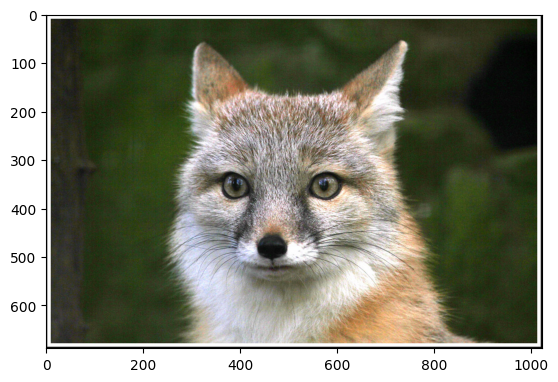

In [48]:
# from torch.utils.data import DataLoader
# import skimage
# import skimage.io as skio
# from matplotlib import pyplot as plt

fox = skio.imread('data/fox.jpeg')
plt.imshow(fox)
batch_size=10000
train_dataset = MyDataset(fox, num_iterations=3000, num_pixels=batch_size)
train_loader = DataLoader(train_dataset)
# train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = train_loader

In [ ]:
fox.shape

(689, 1024, 3)

In [ ]:
np.array(fox/255).reshape(-1, 3).shape

In [15]:
def savefig(filename, fig):
    fig.savefig('output/' + filename, dpi=fig.dpi)

In [50]:
height, width = train_dataset.height, train_dataset.width
y, x = torch.meshgrid(torch.arange(height), torch.arange(width))
index = torch.cat((y.flatten()[:, None]/height, x.flatten()[:, None]/width), dim=1)
org_input = positional_encoding(index, layers, height*width)

In [83]:
psnrman = []

In [30]:
psnr = []
psnr1 = []
psnr2 = []

In [84]:
save_dir = '/logs'
tb_writer = SummaryWriter(log_dir=save_dir)

net = Net().to(device)
criterion = nn.MSELoss()  # nn.MSELoss() nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# loop over the dataset multiple times
iterations = 1
# then set image = resized_image
image = fox
reconstruct_image = np.zeros_like(image)
# try iteration of lr=1e-3, channels=512
# try iteration of lr=1e-3, layers=15
prints = [100, 500, 1000, 2999]
for iteration in range(iterations):
    # y, x = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    # indices = np.concatenate([x[:, :, None], y[:, :, None]], axis = 2)
    # indices = positional_encoding(indices)
    # Wrap in a progress bar to display progress during training.

    # with tqdm(enumerate(train_loader), unit = "batch") as tbatch:
    #   for i, data in tbatch:
    progress_bar = tqdm(train_loader)

    for i, data in enumerate(progress_bar):
      inputs, labels = data
      inputs = torch.squeeze(inputs).to(device)
      labels = labels.to(device)
      # ycoor, xcoor, labels = data
      # labels = labels.cuda()
      # y, x = ycoor / image.shape[0], xcoor / image.shape[1]
      # inputs = positional_encoding(y, x, 10, labels.size(0)).cuda()

      # y = y[:, None]
      # x = x[:, None]
      # inputs = torch.cat([y, x], dim=1).cuda().to(torch.float32)
      # if i % batch_size == 0:
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = i, data

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward pass
      outputs = net(inputs)
      # compute loss
      loss = criterion(outputs, labels.to(torch.float32))

      # if iteration == 1:
      #   reconstruct_image[ycoor, xcoor] = outputs.cpu().detach().numpy()
      # backward pass
      loss.backward()

      # update network parameters
      optimizer.step()

      psnr.append(-10*np.log10(loss.cpu().item()))
      # if i in prints:
      #   im = einops.rearrange(net(org_input.to(device)), '(y x) b -> y x b', y=height, x=width).cpu().detach().numpy()
      #   fig = plt.figure(figsize=(10, 10))
      #   plt.imshow(cv2.normalize(im, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1))
      #   savefig('pic' + str(i), fig)
      progress_bar.set_description(f'Iteration {i + 1}/{3000}, Loss {loss}, PSNR {psnr[i]}')

      # progress_bar.set_description(f'Epoch {iteration + 1}/{10}, Batch {i + 1}/{len(train_loader)}, Loss {loss}')

      # Now use tensorboard for logging, as well as progress bar.
      # global_step = iteration * len(train_loader) + i
      # tb_writer.add_scalar("loss", loss.item(), global_step)
      # tbatch.set_postfix(loss = loss)

print('Finished Training')

Output hidden; open in https://colab.research.google.com to view.

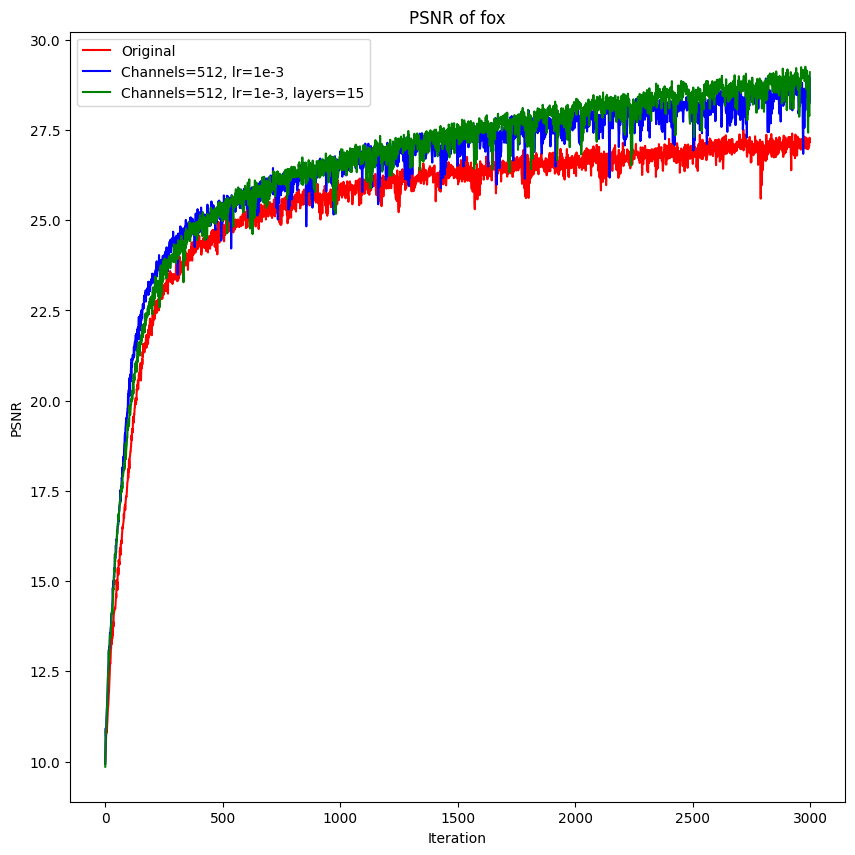

In [42]:
fig = plt.figure(figsize=(10, 10))
plt.title('PSNR of fox')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.plot(range(len(psnr)), psnr, color='red', label='Original')
plt.plot(range(len(psnr1)), psnr1, color='blue', label='Channels=512, lr=1e-3')
plt.plot(range(len(psnr2)), psnr2, color='green', label='Channels=512, lr=1e-3, layers=15')
plt.legend()
savefig('psnr', fig)

In [ ]:
# import cv2
# height, width = train_dataset.height, train_dataset.width
# y, x = torch.meshgrid(torch.arange(height), torch.arange(width))
# index = torch.cat((y.flatten()[:, None]/height, x.flatten()[:, None]/width), dim=1)
# org_input = positional_encoding(index, 10, height*width)
im = einops.rearrange(net(org_input.to(device)), '(y x) b -> y x b', y=height, x=width).cpu().detach().numpy()
plt.imshow(cv2.normalize(im, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1))

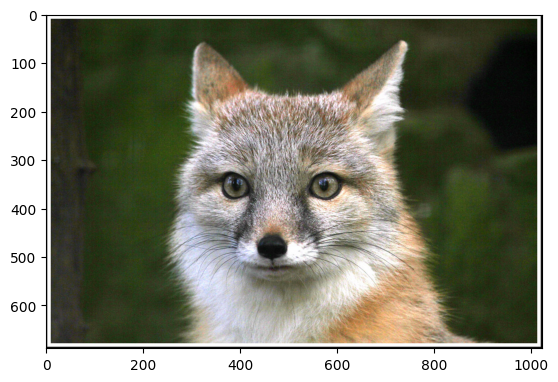

In [ ]:
plt.imshow(fox)

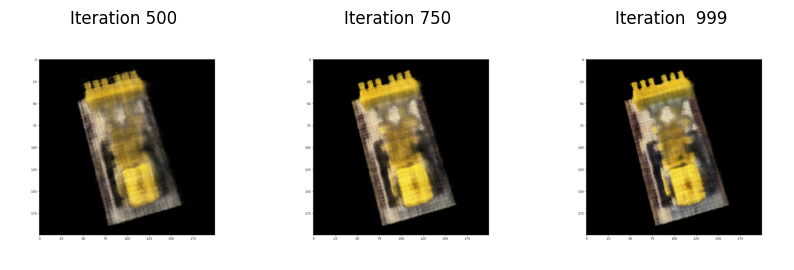

In [31]:
from skimage import io, transform

fig = plt.figure(figsize=(10,10))
plt.subplot(1, 3, 1)
plt.title('Iteration 500')
plt.axis('off')
im = io.imread('output/lego500.png')
plt.imshow(im)
plt.subplot(1, 3, 2)
plt.title('Iteration 750')
plt.axis('off')
im = io.imread('output/lego750.png')
plt.imshow(im)
plt.subplot(1, 3, 3)
plt.title('Iteration  999')
plt.axis('off')
im = io.imread('output/lego999.png')
plt.imshow(im)
savefig('lego2.png', fig)

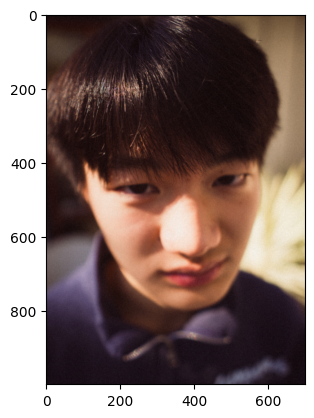

In [78]:
from skimage import io, transform

a = io.imread('data/aaron.jpg')
resized_image = transform.resize(a, (1000, 700))
resized_image = cv2.normalize(resized_image, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
plt.imshow(resized_image)
batch_size=10000
train_dataset = MyDataset(resized_image, num_iterations=3000, num_pixels=batch_size)
train_loader = DataLoader(train_dataset)
# train_loader = DataLoader(train_dataset, batch_size=10000, shuffle=True)
test_loader = train_loader

In [79]:
height, width = train_dataset.height, train_dataset.width
y, x = torch.meshgrid(torch.arange(height), torch.arange(width))
index = torch.cat((y.flatten()[:, None]/height, x.flatten()[:, None]/width), dim=1)
org_input = positional_encoding(index, layers, height*width)

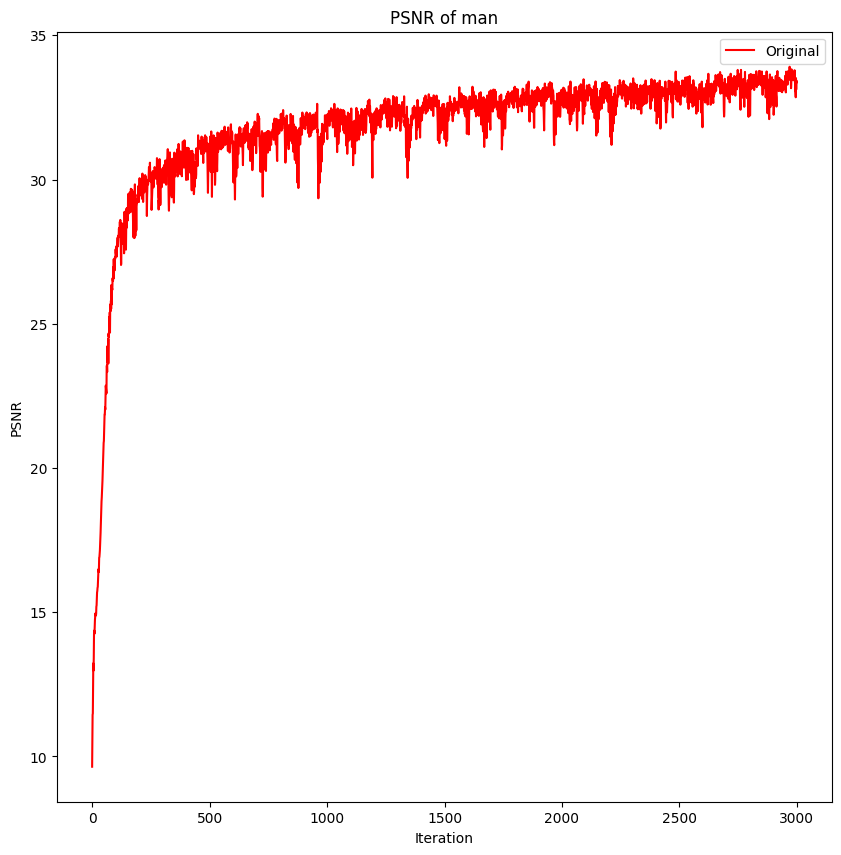

In [85]:
fig = plt.figure(figsize=(10, 10))
plt.title('PSNR of man')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.plot(range(len(psnrman)), psnrman, color='red', label='Original')
plt.legend()
savefig('psnrman', fig)

In [3]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

In [2]:
# x_w = transform(c2w, x_c)
# x == transform(c2w.inv(), transform(c2w, x))
def transform(c2w, x_c):
  # c2w is 4x4
  # x_c is n x 4
  n = x_c.shape[0]
  assert x_c.shape == (n, 3), f"Expected shape {(n, 3)} but got {x_c.shape}"
  x_c = torch.cat((x_c, torch.from_numpy(np.array([1]*x_c.size(0)))[:, None]), dim=1)
  assert x_c.shape == (n, 4), f"Expected shape {(n, 4)} but got {x_c.shape}"
  # not sure about this
  # c2w = einops.rearrange(c2w, 'a b -> b a')
  # x_w = x_c @ c2w
  # x_c is shape n x 4 but needs to be n x 4 x 1
  x_w = c2w @ x_c[:, :, None]
  x_w = torch.squeeze(x_w)
  assert x_w.shape == (n, 4), f"Expected shape {(n, 4)} but got {x_w.shape}"
  return x_w

In [3]:
# s * uv1 = K * x_c
# pinv K * uvl = x_c / s
# x_c = x_c / s * z_c

# x_c = pixel_to_camera(K, uv, s)
def pixel_to_camera(K, uv, s):
  # uv is of form [u, v].T
  # K shape 3x3
  # uv shape is nx3
  # s shape is 1
  n = uv.shape[0]
  assert uv.size() == (n, 2), f"Expected shape {(n, 2)} but got {uv.shape}"
  uv = torch.cat((uv, torch.from_numpy(np.array([1]*uv.size(0)))[:, None]), dim=1)
  assert uv.size() == (n, 3), f"Expected shape {(n, 3)} but got {uv.shape}"
  # K = einops.rearrange(K, 'a b -> b a')
  # not sure about this
  x_c = torch.linalg.pinv(K) @ uv.type(torch.DoubleTensor)[:, :, None]
  x_c = torch.squeeze(x_c)
  # x_c = uv.type(torch.DoubleTensor) @ torch.linalg.pinv(K)
  assert x_c.size() == (n, 3), f"Expected shape {(n, 3)} but got {x_c.shape}"
  return x_c * s

In [5]:
# # ray_o, ray_d = pixel_to_ray(K, c2w, uv)
# def pixel_to_ray(K, c2w, uv):
#   # K is shape 3 x 3
#   # uv is shape n x 2
#   n = uv.shape[0]
#   s = 1
#   x_c = pixel_to_camera(K, uv, s)
#   assert x_c.shape == (n, 3), f"Expected shape {(n, 3)} but got {x_c.shape}"
#   x_w = transform(c2w, x_c)
#   # assert x_c == transform(torch.linalg.pinv(c2w), transform(c2w, x_c))
#   assert x_w.shape == (n, 4), f"Expected shape {(n, 4)} but got {x_w.shape}"

#   # c2w should be a 4x4
#   rotation = torch.linalg.inv(c2w)[:3, :3]
#   translation = torch.linalg.inv(c2w)[:3, 3][:, None]
#   assert rotation.shape == (3, 3), f"Expected shape {(3, 3)} but got {rotation.shape}"
#   assert translation.shape == (3, 1), f"Expected shape {(3, 1)} but got {translation.shape}"
#   r_o = -1 * torch.linalg.pinv(rotation) @ translation
#   assert r_o.shape == (3, 1), f"Expected shape {(3, 1)} but got {r_o.shape}"
#   # x_w shape is nx4
#   r_o = einops.repeat(r_o, 'B D -> (N D) B', N = n)
#   # r_o = np.repeat(r_o, n, axis=1).T
#   r_d = (x_w[:, :3] - r_o) / torch.linalg.norm(torch.abs(x_w[:, :3] - r_o))
#   assert r_d.shape == (n, 3), f"Expected shape {(n, 3)} but got {r_d.shape}"
#   # r_o is shape 3x1 r_d is shape nx3
#   return r_o, r_d

In [4]:
# ray_o, ray_d = pixel_to_ray(K, c2w, uv)
def pixel_to_ray(K, c2w, uv):
  # K is shape 3 x 3
  # uv is shape n x 2
  n = uv.shape[0]
  s = 1
  x_c = pixel_to_camera(K, uv, s)
  #assert x_c.shape == (n, 3), f"Expected shape {(n, 3)} but got {x_c.shape}"
  x_w = transform(c2w, x_c)
  # assert x_c == transform(torch.linalg.pinv(c2w), transform(c2w, x_c))
  #assert x_w.shape == (n, 4), f"Expected shape {(n, 4)} but got {x_w.shape}"

  # c2w should be a 4x4
  rotation = torch.linalg.inv(c2w)[:, :3, :3]
  translation = torch.linalg.inv(c2w)[:, :3, 3][:, :, None]
  #assert rotation.shape == (n, 3, 3), f"Expected shape {(n, 3, 3)} but got {rotation.shape}"
  #assert translation.shape == (n, 3, 1), f"Expected shape {(n, 3, 1)} but got {translation.shape}"
  r_o = -1 * torch.linalg.pinv(rotation) @ translation
  r_o = r_o.squeeze()
  #assert r_o.shape == (n, 3), f"Expected shape {(n, 3)} but got {r_o.shape}"
  # x_w shape is nx4
  # r_o = einops.repeat(r_o, 'B D -> (N D) B', N = n)

  # r_o = np.repeat(r_o, n, axis=1).T
  # r_d = torch.zeros((n, 3))
  # for i in range(n):
  #   r_d[i] = (x_w[i, :3] - r_o[i]) / torch.linalg.norm(torch.abs(x_w[i, :3] - r_o[i]))
  r_d = (x_w[:, :3] - r_o) / torch.linalg.norm(torch.abs(x_w[:, :3] - r_o), dim=1, keepdim=True)
  # r_d = (x_w[:, :3] - r_o) / torch.linalg.norm(torch.abs(x_w[:, :3] - r_o), dim=0)
  #assert r_d.shape == (n, 3), f"Expected shape {(n, 3)} but got {r_d.shape}"
  # r_o is shape 3x1 r_d is shape nx3
  return r_o, r_d

In [ ]:
# height, width = 200, 200
# y, x = torch.meshgrid(torch.arange(height), torch.arange(width))
# y, x = y.flatten()[:, None, None], x.flatten()[:, None, None]
# uv = torch.cat((y, x), dim=1) + 0.5
# K = torch.tensor(np.array([
#     [focal, 0, height/2],
#     [0, focal, width/2],
#     [0, 0, 1]
# ]))
# c2w = c2ws_train

Part 2.2: Sampling

In [ ]:
# def sample_rays(images, b, n):
#   # sample b rays from the images
#   # sample n points from the b rays
#   num_images, height, width = images.shape[0], images.shape[1], images.shape[2]
#   rays = torch.randint(0, num_images, (b,))
#   r_o, r_d = torch.zeros(b, n//b, 3), torch.zeros(b, n//b, 3)
#   for i in range(b):
#     batch = rays[i]
#     indices = torch.randint(0, height*width, (n//b,))
#     y, x = indices // height, indices % height
#     y, x = y.flatten()[:, None], x.flatten()[:, None]
#     uv = torch.cat((y, x), dim=1) + 0.5
#     K = torch.tensor(np.array([
#         [focal, 0, height/2],
#         [0, focal, width/2],
#         [0, 0, 1]
#     ]))
#     c2w = torch.from_numpy(c2ws_train[batch])
#     # r_o[i] shape is n x 3
#     r_o[i], r_d[i] = pixel_to_ray(K, c2w, uv)
#   return r_o, r_d

In [ ]:
# r_o, r_d = sample_rays(images_train, 2, 50)

In [ ]:
# def sample_along_rays(r_o, r_d, perturb=True):
#   # for 1 point
#   # x = r_o + r_d * t
#   # t scales r_d
#   # t has shape nx1
#   n = 64
#   batches, samples = r_o.shape[0], r_o.shape[1]
#   points = torch.zeros(batches, samples, n, 3)
#   for i in range(batches):
#     for j in range(samples):
#       t = np.linspace(2.0, 6.0, n)
#       if perturb:
#         t = t + (np.random.rand(t.shape[0]))
#       for k in range(t.shape[0]):
#         points[i, j, k] = r_o[i, j]+ torch.mul(r_d[i, j], t[k])
#   return points

In [ ]:
# sample_along_rays(r_o, r_d).shape

In [5]:
# from torch.utils.data import Dataset
# dataset = RaysData(images_train, K, c2ws_train)
class RaysData():
  def __init__(self, image_train, K, c2ws_train):
    # self.height = self.image_train.shape[1]
    # self.width = self.image_train.shape[2]
    self.image_train = image_train
    self.K = K
    self.c2ws_train = c2ws_train
    # make sure 2*num_images <= batches
    self.num_images = 50
    # self.n = n
    # b = self.num_images
    # self.r_o, self.r_d, self.pixels = torch.zeros(b, n//b, 3), torch.zeros(b, n//b, 3), torch.zeros(b, n//b, 3)

    # y, x = torch.meshgrid(torch.arange(images_train.shape[1]), torch.arange(images_train.shape[2]))
    # y, x = y.flatten()[:, None], x.flatten()[:, None]
    # self.uvs = torch.cat((x, y), dim=1)
    # self.pixels = image_train[0]
    # self.pixels = einops.rearrange(self.pixels, 'a b c -> (a b) c')
    # self.rays_o, self.rays_d, _ = self.sample_rays(40000)

  # def __getitem__(self, index: int):
  #   indices = torch.randint(0, self.height*self.width, (self.num_pixels,))
  #   index = torch.cat((self.yindices[indices // self.width][:, None], self.xindices[indices % self.width][:, None]), dim=1)

  #   return index

  # def __len__(self) -> int:
  #   return self.num_iterations

  # def sample_rays(self, n):
  #   # sample b rays from the images
  #   # sample n points from the b rays
  #   images = self.image_train
  #   b = self.num_images
  #   num_images, height, width = images.shape[0], images.shape[1], images.shape[2]
  #   rays = torch.randint(0, num_images, (b,))
  #   r_o, r_d, pixels = torch.zeros(b, n//b, 3), torch.zeros(b, n//b, 3), torch.zeros(b, n//b, 3)
  #   for i in range(b):
  #     # batch = 0
  #     batch = rays[i]
  #     indices = torch.randint(0, height*width, (n//b,))
  #     y, x = indices // height, indices % height
  #     assert self.image_train[batch, y, x, :].shape == (n//b, 3), f"Expect shape {(n//b, 3)}, but got {self.image_train[batch, y, x, :].shape}"
  #     pixels[i] = torch.from_numpy(self.image_train[batch, y, x, :])
  #     y, x = y.flatten()[:, None], x.flatten()[:, None]
  #     uv = torch.cat((x, y), dim=1) + 0.5
  #     # K = torch.tensor(np.array([
  #     #     [focal, 0, height/2],
  #     #     [0, focal, width/2],
  #     #     [0, 0, 1]
  #     # ]))
  #     c2w = torch.from_numpy(self.c2ws_train[batch])
  #     # r_o[i] shape is n x 3
  #     r_o[i], r_d[i] = pixel_to_ray(self.K, c2w, uv)

  #   r_o = einops.rearrange(r_o, 'a b c -> (a b) c')
  #   r_d = einops.rearrange(r_d, 'a b c -> (a b) c')
  #   pixels = einops.rearrange(pixels, 'a b c -> (a b) c')
  #   return r_o, r_d, pixels


  def sample_rays(self, n):
    image = self.image_train
    indices = (torch.rand(n) * image.shape[0] * image.shape[1] * image.shape[2]).type(torch.int32)
    camera_index = indices // (image.shape[1] * image.shape[2])
    f_indices = indices % (image.shape[1] * image.shape[2])
    row_indices = f_indices // image.shape[2]
    col_indices = f_indices % image.shape[2]
    cameras = self.c2ws_train[camera_index, :, :] #(B, 4, 4)
    uv = torch.stack((col_indices, row_indices), dim = 1) + 0.5 #(B, 2)
    assert uv.shape == (n, 2)
    r0, rd = pixel_to_ray(self.K, torch.from_numpy(cameras), uv)
    pixels = torch.from_numpy(self.image_train[camera_index, row_indices, col_indices])
    return r0, rd, pixels


  # # choose n points at random
  # def sample_rays(self, n):
  #   image = self.image_train

  #   # Randomly select n elements from the array
  #   image_shape = (image.shape[0], image.shape[1], image.shape[2])
  #   mask = np.zeros(image_shape, dtype=bool)
  #   mask.ravel()[np.random.choice(mask.size, size=n, replace=False)] = True
  #   indices = np.argwhere(mask)
  #   batch, y, x = indices[:, 0], indices[:, 1][:, None], indices[:, 2][:, None]
  #   # Index back into the original array using the reshaped indices
  #   pixels = torch.from_numpy(self.image_train[batch, y, x])
  #   c2w = torch.from_numpy(self.c2ws_train[batch])
  #   uv = np.concatenate((x, y), axis=1) + 0.5
  #   uv = torch.from_numpy(uv)
  #   r_o, r_d = pixel_to_ray(self.K, c2w, uv)
  #   return r_o, r_d, pixels



def sample_along_rays(r_o, r_d, perturb=True):
  # for 1 point
  # x = r_o + r_d * t
  # t scales r_d
  # t has shape nx1
  n = 64
  batch = r_o.shape[0]
  points = torch.zeros(batch, n, 3)
  t = torch.linspace(2.0, 6.0, n)
  if perturb:
    t = t + (np.random.rand(t.shape[0])) * (4./64.)
  t = einops.repeat(t, 'n -> b n', b=batch).type(torch.float32)[:, :, None]
  r_d = einops.repeat(r_d, 'b p -> b N p', N=n)
  r_o = einops.repeat(r_o, 'b p -> b N p', N=n)
  # points has shape of b x n x 3
  points = r_o + r_d * t
  # for i in range(ray_indices):
  #   t = np.linspace(2.0, 6.0, n)
  #   if perturb:
  #     t = t + (np.random.rand(t.shape[0]))
  #   for j in range(t.shape[0]):
  #     points[i, j] = r_o[i]+ torch.mul(r_d[i], t[j])
  return points

In [18]:
num_images, height, width = images_train.shape[0], images_train.shape[1], images_train.shape[2]
K = torch.tensor(np.array([
        [focal, 0, height/2],
        [0, focal, width/2],
        [0, 0, 1]
]))
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(1024)
points = sample_along_rays(rays_o, rays_d, perturb=True)
print(rays_o.shape)
print(points.shape)

torch.Size([1024, 3])
torch.Size([1024, 64, 3])


In [19]:
import viser, time  # pip install viser
import numpy as np
num_images, height, width = images_train.shape[0], images_train.shape[1], images_train.shape[2]
K = torch.tensor(np.array([
        [focal, 0, height/2],
        [0, focal, width/2],
        [0, 0, 1]
]))
# --- You Need to Implement These ------
dataset = RaysData(images_train, K, c2ws_train)
rays_o, rays_d, pixels = dataset.sample_rays(200)
points = sample_along_rays(rays_o, rays_d, perturb=True).numpy()
H, W = images_train.shape[1:3]
# ---------------------------------------

server = viser.ViserServer(share=True)
for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
    server.add_camera_frustum(
        f"/cameras/{i}",
        fov=2 * np.arctan2(H / 2, K[0, 0]),
        aspect=W / H,
        scale=0.15,
        wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
        position=c2w[:3, 3],
        image=image
    )
for i, (o, d) in enumerate(zip(rays_o, rays_d)):
    server.add_spline_catmull_rom(
        f"/rays/{i}", positions=np.stack((o, o + d * 6.0)),
    )
server.add_point_cloud(
    f"/samples",
    colors=np.zeros_like(points).reshape(-1, 3),
    points=points.reshape(-1, 3),
    point_size=0.02,
)
time.sleep(1000)

(viser) Share URL requested! (expires in 24 hours)

╭─────────────────────────── viser ────────────────────────────╮
│             ╷                                                │
│   HTTP      │ http://0.0.0.0:8082                            │
│   Websocket │ ws://0.0.0.0:8082                              │
│   Share URL │ https://adaptive-skeleton.share.viser.studio   │
│             ╵                                                │
╰──────────────────────────────────────────────────────────────╯

(viser) Connection opened (0, 1 total), 505 persistent messages

(viser) Connection closed (0, 0 total)

KeyboardInterrupt: ignored

In [ ]:
np.sum(images_train[0, sample_uvs[:,0], sample_uvs[:,1]] == dataset.pixels[uvs_start:uvs_end])

120000

In [ ]:
dataset.pixels[uvs_start:uvs_end].shape

(40000, 3)

In [ ]:
# # Visualize Cameras, Rays and Samples
# # import viser, time
# # import numpy as np
# num_images, height, width = images_train.shape[0], images_train.shape[1], images_train.shape[2]
# K = torch.tensor(np.array([
#         [focal, 0, height/2],
#         [0, focal, width/2],
#         [0, 0, 1]
# ]))
# # --- You Need to Implement These ------
# dataset = RaysData(images_train, K, c2ws_train)

# # This will check that your uvs aren't flipped
# uvs_start = 0
# uvs_end = 40_000
# sample_uvs = dataset.uvs[uvs_start:uvs_end] # These are integer coordinates of widths / heights (xy not yx) of all the pixels in an image
# # uvs are array of xy coordinates, so we need to index into the 0th image tensor with [0, height, width], so we need to index with uv[:,1] and then uv[:,0]
# print(images_train[0, sample_uvs[:,1], sample_uvs[:,0]].shape)
# print(dataset.pixels[uvs_start:uvs_end].shape)
# assert np.all(images_train[0, sample_uvs[:,1], sample_uvs[:,0]] == dataset.pixels[uvs_start:uvs_end])

# # # Uncoment this to display random rays from the first image
# indices = np.random.randint(low=0, high=40_000, size=100)

# # # Uncomment this to display random rays from the top left corner of the image
# # indices_x = np.random.randint(low=100, high=200, size=100)
# # indices_y = np.random.randint(low=0, high=100, size=100)
# # indices = indices_x + (indices_y * 200)

# data = {"rays_o": dataset.rays_o[indices], "rays_d": dataset.rays_d[indices]}
# points = sample_along_rays(data["rays_o"], data["rays_d"], perturb=True).numpy()
# # ---------------------------------------

# server = viser.ViserServer(share=True)
# for i, (image, c2w) in enumerate(zip(images_train, c2ws_train)):
#   server.add_camera_frustum(
#     f"/cameras/{i}",
#     fov=2 * np.arctan2(H / 2, K[0, 0]),
#     aspect=W / H,
#     scale=0.15,
#     wxyz=viser.transforms.SO3.from_matrix(c2w[:3, :3]).wxyz,
#     position=c2w[:3, 3],
#     image=image
#   )
# for i, (o, d) in enumerate(zip(data["rays_o"], data["rays_d"])):
#   positions = np.stack((o, o + d * 6.0))
#   server.add_spline_catmull_rom(
#       f"/rays/{i}", positions=positions,
#   )
# server.add_point_cloud(
#     f"/samples",
#     colors=np.zeros_like(points).reshape(-1, 3),
#     points=points.reshape(-1, 3),
#     point_size=0.03,
# )
# time.sleep(1000)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


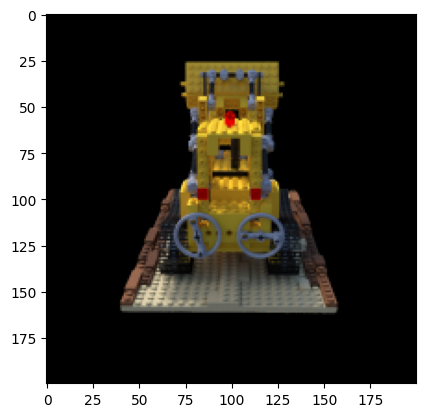

In [ ]:
plt.imshow(images_train[0])

In [6]:
# import math
# import torch.nn.functional as F
# import numpy as np
# import einops

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# takes a coordinate and transforms it to {x, sin(2**0pix), cos(2**0pix), ... sin(2**L-1pix), cos(2**L-1pix)}
def positional_encoding3D(indices, L, shape):
  # x = einops.rearrange(x, 'a b c -> (b c) a')
  # y = einops.rearrange(y, 'a b c -> (b c) a')
  batch, points = shape
  layers = 2*L+1
  # layers = 42 with L = 10 for 2D coordinate
  encoding = torch.zeros(batch, points, 3*layers)
  y, x, z = indices[:, :, 0], indices[:, :, 1], indices[:, :, 2]
  encoding[:, :, 1] = x
  encoding[:, :, 0] = y
  encoding[:, :, 2] = z
  pos = 3
  for i in range(L):
    encoding[:, :, pos] = np.sin(2**i*math.pi*y)
    encoding[:, :, pos+1] = np.cos(2**i*math.pi*y)
    encoding[:, :, pos+2] = np.sin(2**i*math.pi*x)
    encoding[:, :, pos+3] = np.cos(2**i*math.pi*x)
    encoding[:, :, pos+4] = np.sin(2**i*math.pi*z)
    encoding[:, :, pos+5] = np.cos(2**i*math.pi*z)
    pos += 6
  # print(encoding[:, 0])
  # print(encoding[:, 1])
  # print(encoding[:, 2])
  # print(encoding[:, 3])
  # print(encoding[:, 6])
  # print(encoding[:, 7])
  # print(y)
  # print(x)

  # if rays:
  #   encoding = einops.rearrange(encoding, 'a b c -> (a b) c')
  return encoding.to(device)

class NerfNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(63, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 256)
    self.fc5 = nn.Linear(319, 256)
    self.fc6 = nn.Linear(256, 256)
    self.fc7 = nn.Linear(256, 256)
    self.fc8 = nn.Linear(256, 256)
    self.fcDen1 = nn.Linear(256, 1)
    self.fcRGB1 = nn.Linear(256, 256)
    self.fcRGB2 = nn.Linear(283, 128)
    self.fcRGB3 = nn.Linear(128, 3)
    self.sigmoid = torch.nn.Sigmoid()

    # self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
    # self.conv2 = nn.Conv2d(32, 64, 3, 1)  # 32 x H x W -> 64 x H - 2 x W - 2 (max pool)
    # self.fc1 = nn.Linear(9216, 128) # 64 x H x W -> 92618 -> 128
    # self.fc2 = nn.Linear(128, 10)

  def forward(self, x, r_d):
    num_samples = x.shape[1]
    p_enc_x = positional_encoding3D(x.cpu().detach(), 10, (x.shape[0], x.shape[1]))
    x = self.fc1(p_enc_x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    # 10000 x 64 x 256
    # should be 10000 x 64 x 27
    x = torch.concat((x, p_enc_x), dim=2)
    x = self.fc5(x)
    x = F.relu(x)
    x = self.fc6(x)
    x = F.relu(x)
    x = self.fc7(x)
    x = F.relu(x)
    x = self.fc8(x)
    density = self.fcDen1(x)
    density = F.relu(density)
    r_d = einops.repeat(r_d, 'B D -> B N D', N = num_samples)
    p_enc_r_d = positional_encoding3D(r_d.cpu().detach(), 4, (r_d.shape[0], r_d.shape[1]))
    RGB = self.fcRGB1(x)
    RGB = torch.concat((RGB, p_enc_r_d), dim=2)
    RGB = self.fcRGB2(RGB)
    RGB = F.relu(RGB)
    RGB = self.fcRGB3(RGB)
    output = self.sigmoid(RGB)

    return output, density

net = NerfNet()
print(net)

NerfNet(
  (fc1): Linear(in_features=63, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=319, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=256, bias=True)
  (fc7): Linear(in_features=256, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=256, bias=True)
  (fcDen1): Linear(in_features=256, out_features=1, bias=True)
  (fcRGB1): Linear(in_features=256, out_features=256, bias=True)
  (fcRGB2): Linear(in_features=283, out_features=128, bias=True)
  (fcRGB3): Linear(in_features=128, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)


In [7]:
def volrend(sigmas, rgbs, step_size):
  # deltas are equal size blocks that make up the ray
  pdf_ray_termination = (torch.exp(-torch.cumsum(sigmas*step_size, dim=1) + sigmas*step_size)) * (1-torch.exp(-sigmas*step_size))
  ray_color = torch.sum(pdf_ray_termination * rgbs, dim=1)
  return ray_color

In [8]:
torch.manual_seed(42)
sigmas = torch.rand((10, 64, 1))
rgbs = torch.rand((10, 64, 3))
step_size = (6.0 - 2.0) / 64
rendered_colors = volrend(sigmas, rgbs, step_size)
correct = torch.tensor([
    [0.5006, 0.3728, 0.4728],
    [0.4322, 0.3559, 0.4134],
    [0.4027, 0.4394, 0.4610],
    [0.4514, 0.3829, 0.4196],
    [0.4002, 0.4599, 0.4103],
    [0.4471, 0.4044, 0.4069],
    [0.4285, 0.4072, 0.3777],
    [0.4152, 0.4190, 0.4361],
    [0.4051, 0.3651, 0.3969],
    [0.3253, 0.3587, 0.4215]
  ])
assert torch.allclose(rendered_colors, correct, rtol=1e-4, atol=1e-4)


In [9]:
data = np.load(f"lego_200x200.npz")

# Training images: [100, 200, 200, 3]
images_train = data["images_train"] / 255.0

# Cameras for the training images
# (camera-to-world transformation matrix): [100, 4, 4]
c2ws_train = data["c2ws_train"]

# Validation images:
images_val = data["images_val"] / 255.0

# Cameras for the validation images: [10, 4, 4]
# (camera-to-world transformation matrix): [10, 200, 200, 3]
c2ws_val = data["c2ws_val"]

# Test cameras for novel-view video rendering:
# (camera-to-world transformation matrix): [60, 4, 4]
c2ws_test = data["c2ws_test"]

# Camera focal length
focal = data["focal"]  # float

In [10]:
def reconstruct(model, c2w, bsz):
  with torch.no_grad():
    indices = torch.cartesian_prod(torch.arange(200), torch.arange(200)) #(40000, 2)
    r0, rd = pixel_to_ray(dataset.K, c2w[None, :, :], indices)
    r0 = einops.repeat(r0, 'D -> B D', B = 40000)
    xw = sample_along_rays(r0, rd, perturb = False)
    rd, r0, xw = rd.to(device), r0.to(device), xw.to(device)
    sigmas, rgbs = [], []
    for i in range(0, 40000, bsz):
      rd_batch, xw_batch = rd[i : i + bsz, :], xw[i : i + bsz, :, :]
      rgb, density = net(xw_batch, rd_batch)
      sigmas.append(density)
      rgbs.append(rgb)
    sigmas, rgbs = torch.cat(sigmas, dim = 0), torch.cat(rgbs, dim = 0)
    rendered = volrend(sigmas, rgbs, step_size)
    img = einops.rearrange(rendered, '(H W) C -> H W C', H = 200, W = 200).detach().cpu().transpose(0, 1)
  return img

In [11]:
psnr_train = []
psnr_valid = []

Iteration 1000/10, Loss 0.0044145360589027405, PSNR 23.551149314172473: 100%|██████████| 1000/1000 [12:19<00:00,  1.35it/s]


Finished Training


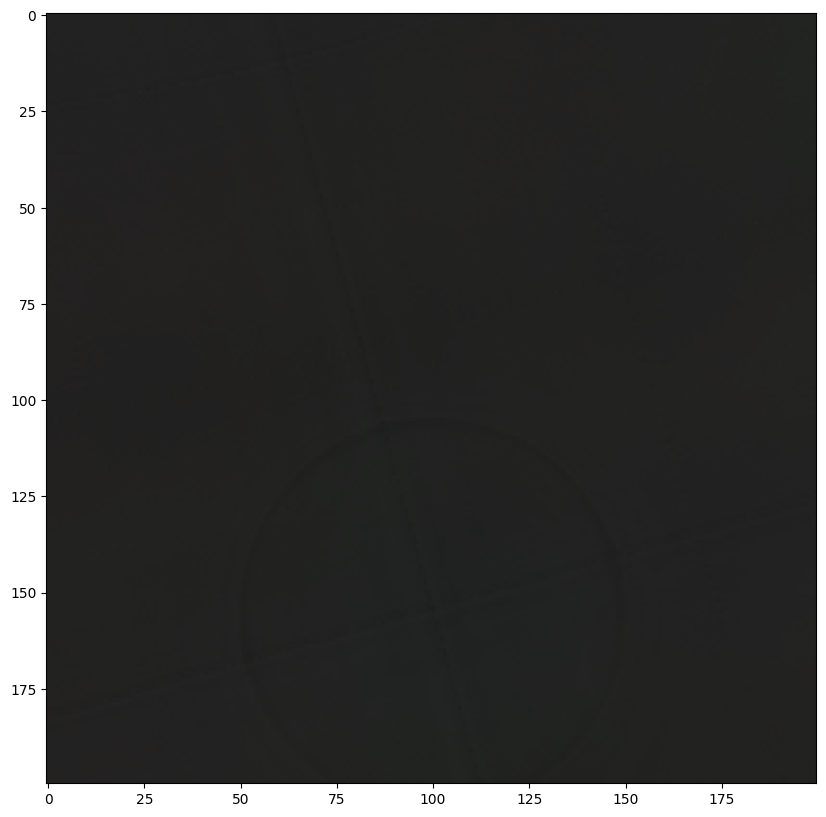

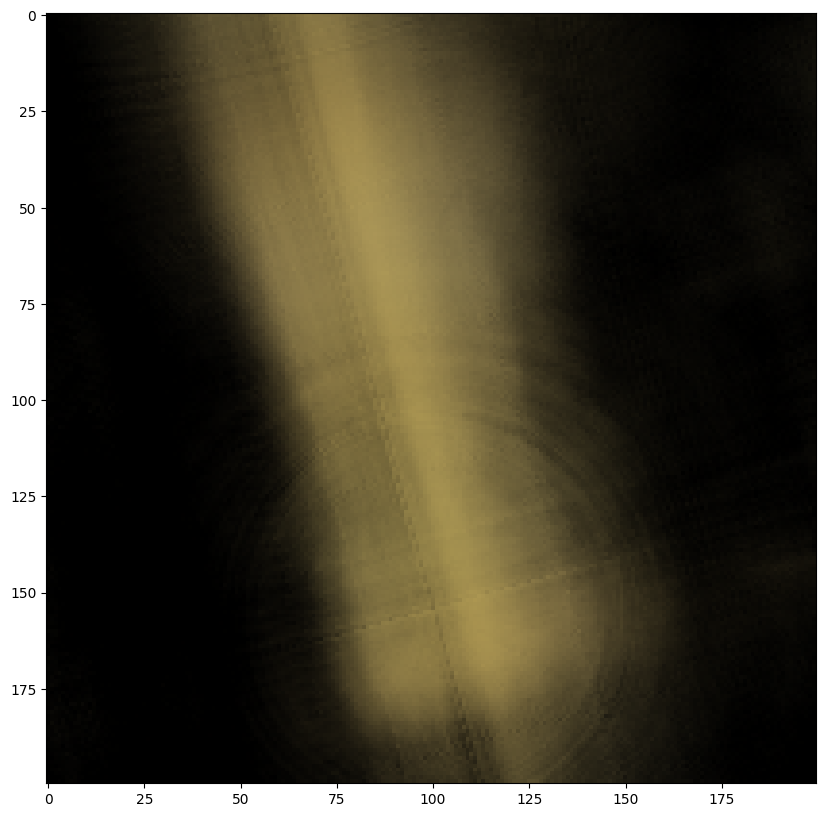

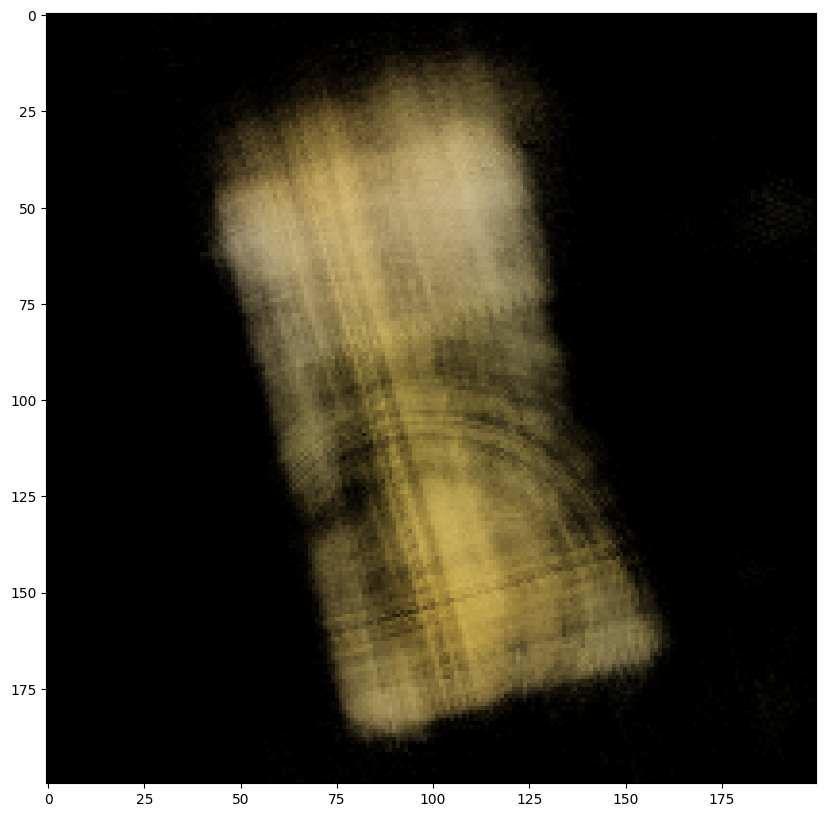

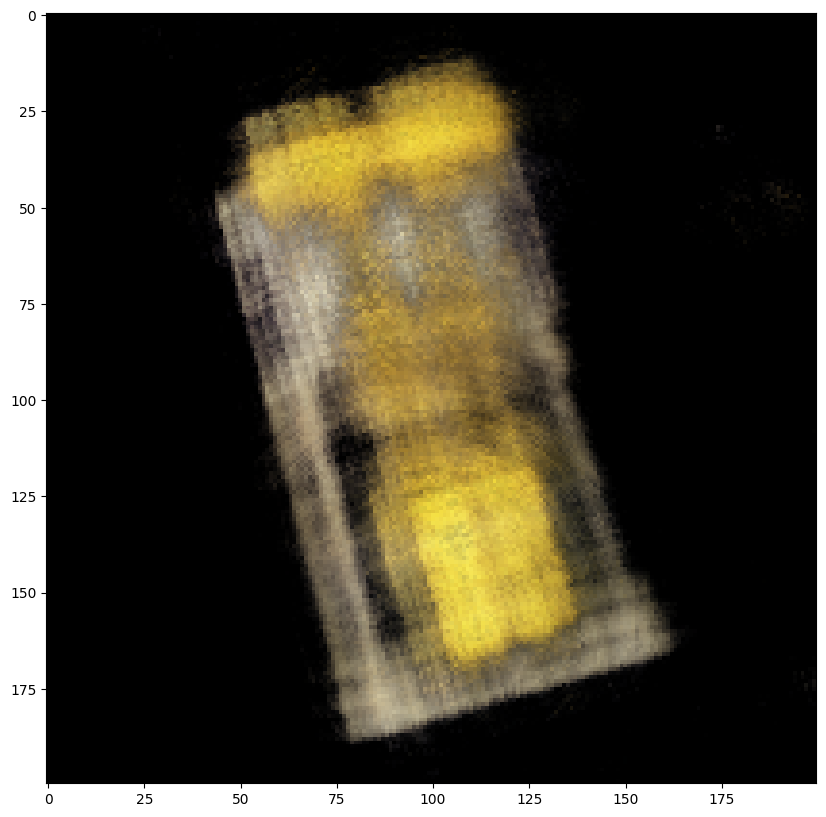

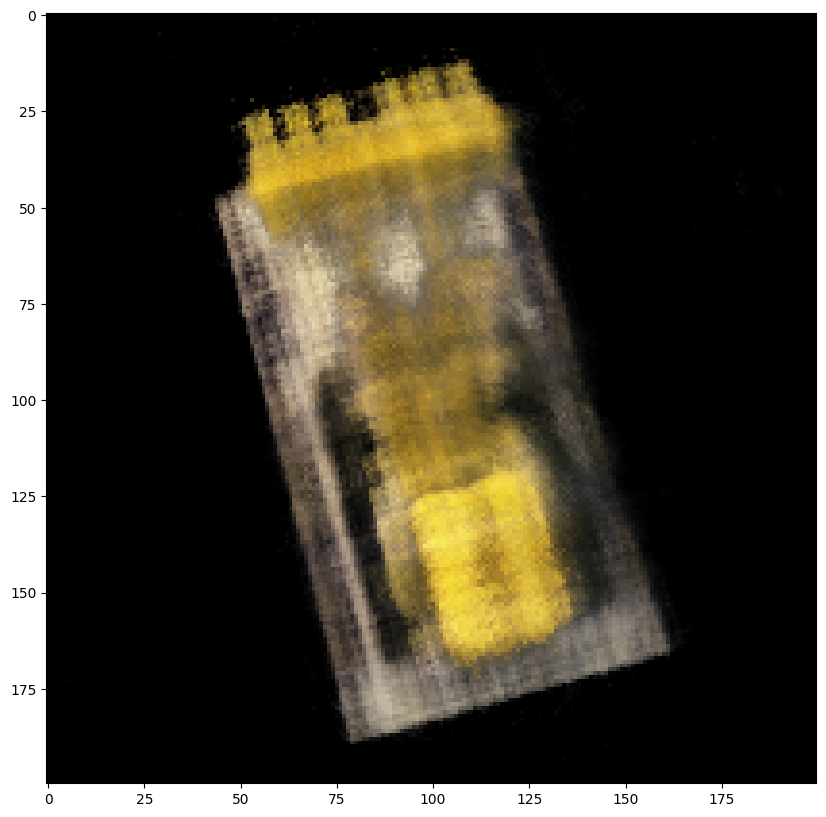

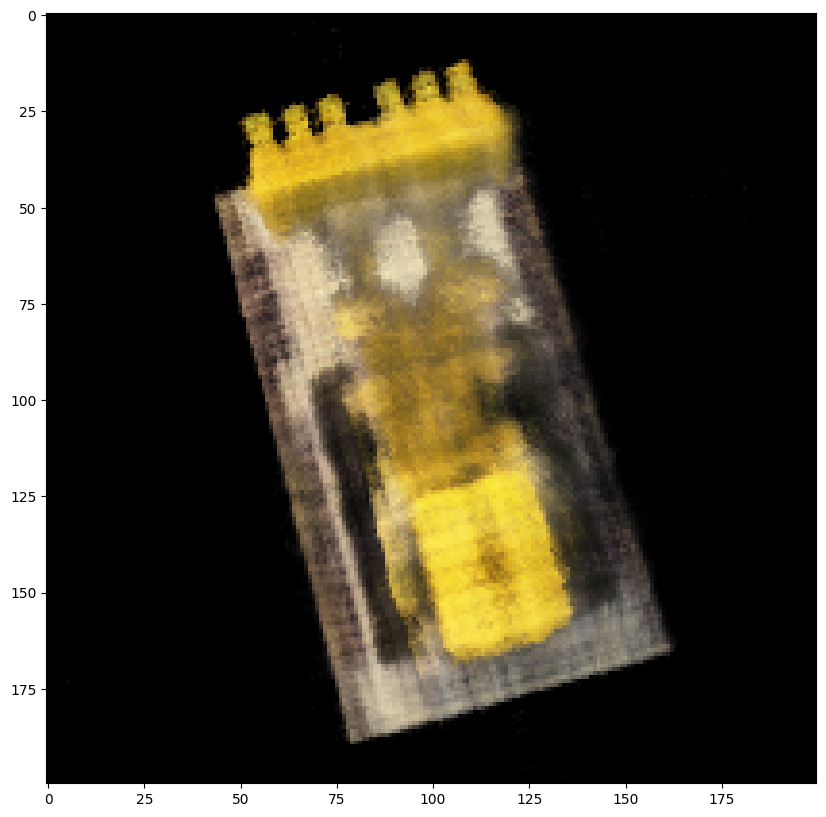

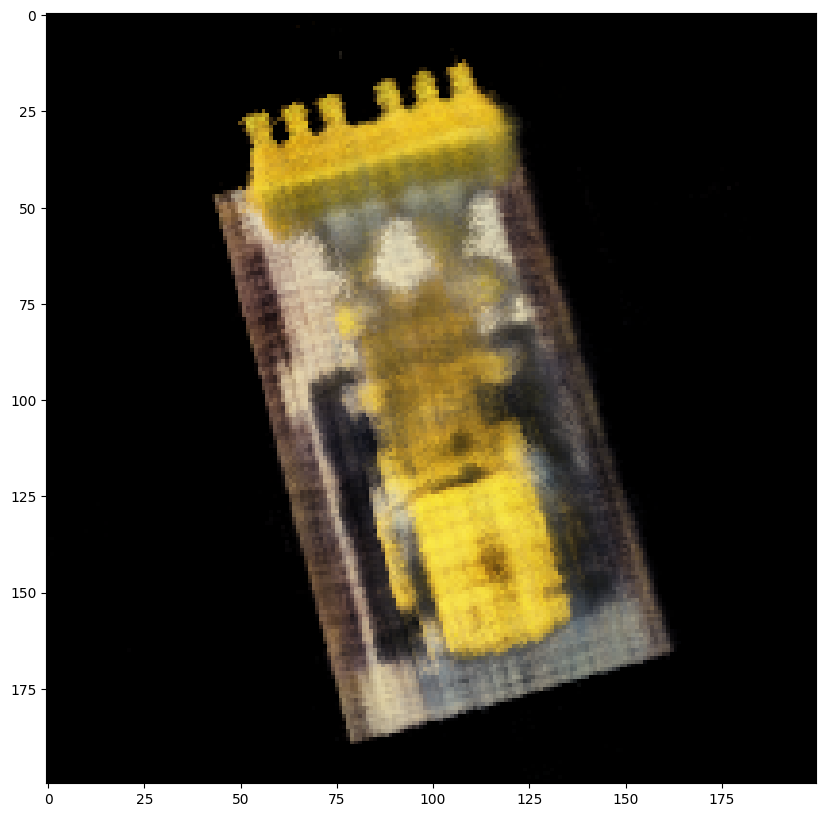

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = '/logs'
tb_writer = SummaryWriter(log_dir=save_dir)
torch.manual_seed(42)
net = NerfNet().to(device)
criterion = nn.MSELoss()  # nn.MSELoss() nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

# --- You Need to Implement These ------
H, W = images_train.shape[1:3]
K = torch.tensor(np.array([
      [focal, 0, H/2],
      [0, focal, W/2],
      [0, 0, 1]
  ]))
# can change this to images_val, c2ws_val
# psnr_valid=[]
# dataset = RaysData(images_val, K, c2ws_val)
dataset = RaysData(images_train, K, c2ws_train)
# rays_o, rays_d, pixels = dataset.sample_rays(10000)
# points = sample_along_rays(rays_o, rays_d, perturb=True)
step_size = (6.0 - 2.0) / 64
prints = [1, 50, 100, 250, 500, 750, 999]
# ---------------------------------------

# progress_bar = tqdm(zip(images_train, c2ws_train))
# for iteration, (image, c2w) in enumerate(progress_bar):
progress_bar = tqdm(range(1000))
for iteration in progress_bar:
  with torch.no_grad():
    rays_o, rays_d, labels = dataset.sample_rays(4096)
    inputs = sample_along_rays(rays_o, rays_d, perturb=True)

  inputs = inputs.to(device)
  labels = labels.to(device)
  # ycoor, xcoor, labels = data
  # labels = labels.cuda()
  # y, x = ycoor / image.shape[0], xcoor / image.shape[1]
  # inputs = positional_encoding(y, x, 10, labels.size(0)).cuda()

  # y = y[:, None]
  # x = x[:, None]
  # inputs = torch.cat([y, x], dim=1).cuda().to(torch.float32)
  # if i % batch_size == 0:
    # get the inputs; data is a list of [inputs, labels]
    # inputs, labels = i, data

  # zero the parameter gradients
  optimizer.zero_grad()

  # forward pass
  # einops.rearrange(rays_d, '(a b) c -> a b c', a=1000, b=1)
  outputs, density = net(inputs, rays_d)
  # compute loss
  outputs = volrend(density, outputs, step_size)
  loss = criterion(outputs, labels.to(torch.float))

  # if iteration == 1:
  #   reconstruct_image[ycoor, xcoor] = outputs.cpu().detach().numpy()
  # backward pass
  loss.backward()

  # update network parameters
  optimizer.step()
  psnr_valid.append(-10*np.log10(loss.cpu().item()))
  # if iteration in prints:
  #   img = reconstruct(net, torch.tensor(c2ws_val[0]), 5000)
  #   fig = plt.figure(figsize=(10, 10))
  #   plt.imshow(img)
  #   savefig('lego' + str(iteration), fig)

  progress_bar.set_description(f'Iteration {iteration + 1}/{10}, Loss {loss}, PSNR {psnr_valid[iteration]}')

  # Now use tensorboard for logging, as well as progress bar.
  # global_step = iteration * len(train_loader) + i
  # tb_writer.add_scalar("loss", loss.item(), global_step)
  # tbatch.set_postfix(loss = loss)

print('Finished Training')

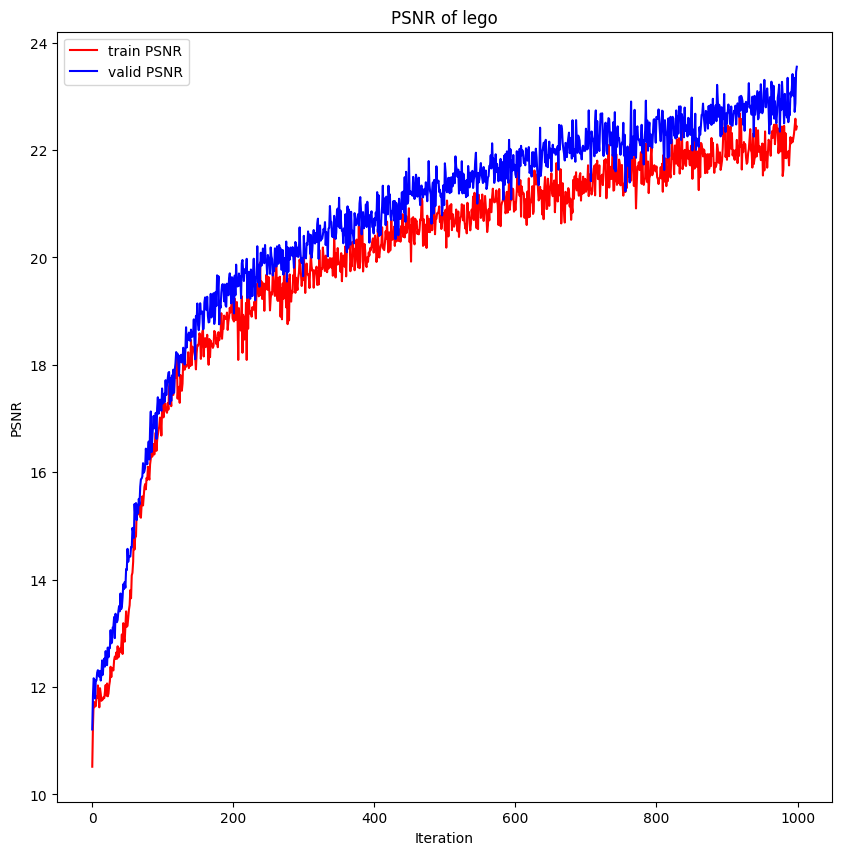

In [22]:
fig = plt.figure(figsize=(10, 10))
plt.title('PSNR of lego')
plt.xlabel('Iteration')
plt.ylabel('PSNR')
plt.plot(range(len(psnr_train)), psnr_train, color='red', label='train PSNR')
plt.plot(range(len(psnr_valid)), psnr_valid, color='blue', label='valid PSNR')
plt.legend()
savefig('psnrlego', fig)

In [15]:
torch.save(net.state_dict(), "MODEL WEIGHTS")

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = NerfNet().to(device)
net.load_state_dict(torch.load("MODEL WEIGHTS"))
net.eval()

NerfNet(
  (fc1): Linear(in_features=63, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=319, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=256, bias=True)
  (fc7): Linear(in_features=256, out_features=256, bias=True)
  (fc8): Linear(in_features=256, out_features=256, bias=True)
  (fcDen1): Linear(in_features=256, out_features=1, bias=True)
  (fcRGB1): Linear(in_features=256, out_features=256, bias=True)
  (fcRGB2): Linear(in_features=283, out_features=128, bias=True)
  (fcRGB3): Linear(in_features=128, out_features=3, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
H, W = images_train.shape[1:3]
K = torch.tensor(np.array([
      [focal, 0, H/2],
      [0, focal, W/2],
      [0, 0, 1]
  ]))
dataset = RaysData(images_train, K, c2ws_train)
step_size = (6.0 - 2.0) / 64
img = reconstruct(net, torch.tensor(c2ws_test[0]), 5000)

In [15]:
frames = []
for i in range(c2ws_test.shape[0]):
  img = reconstruct(net, torch.tensor(c2ws_test[i]), 5000)
  plt.imshow(img)
  plt.show()
  frames.append(img)

Output hidden; open in https://colab.research.google.com to view.

In [5]:
from matplotlib.animation import FuncAnimation
import matplotlib
from IPython.display import display, clear_output
from IPython import display

matplotlib.use('Agg')
# Create a list of image frames (replace with your own frames)
frames = []

# Replace this with loading your frames (e.g., using cv2.imread)
# For this example, we'll create synthetic frames
for i in range(0, 60):
    t = i / 60
    frame = skio.imread('output/Unknown-' + str(i+1) + '.png')
#     frame = skimage.img_as_float(frame)
#     frame = cv2.normalize(frame, None, 255,0, cv2.NORM_MINMAX, cv2.CV_8UC1)
    frames.append(frame)

# Create a function to update the animation frames
def update(frame):
    plt.clf()  # Clear the previous frame
    plt.axis('off')
    plt.imshow(frames[frame]) # Display the current frame

# Create the animation
Figure = plt.figure(figsize=(10, 10))
ani = FuncAnimation(Figure, update, frames=len(frames), repeat=True, interval=50)  # Adjust interval as needed

video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

# good practice to close the plt object.

# Save the animation as a GIF (or other formats)
ani.save('animation.gif', writer='pillow', fps=10)  # Adjust file name, writer, and fps as needed
